In [167]:
import scipy
from itertools import repeat
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [168]:
def repeater(loader):
    for loader in repeat(loader):
        for data in loader:
            yield data


def dataloader(data, batch_size, num_workers):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    
    data=torchvision.datasets.CIFAR100("content/",train=True,download=True,transform=transform)
    return repeater(
            torch.utils.data.DataLoader(
                data, batch_size=batch_size, num_workers=1,
                shuffle=True, drop_last=True, pin_memory=True))


def get_data(batch_size, num_workers):

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    data=torchvision.datasets.CIFAR100("content/",train=True,download=True,transform=transform)
    
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    return torch.utils.data.DataLoader(
                data, batch_size=batch_size, num_workers=1,
                shuffle=True, drop_last=True, pin_memory=True)


class Wrap(object):
    def __init__(self, data, batch_size, samples, num_workers):
        self.data = dataloader(data, batch_size, num_workers)
        self.samples = samples

    def __iter__(self):
        for i in range(self.samples):
            yield next(self.data)

    def __len__(self):
        return self.samples

In [169]:
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models.inception import inception_v3
import torchvision

from  scipy.linalg import sqrtm as sqrtmfunction

INCEPTION_POOL3_DIM = 2048
EPS = 1e-6

cache = {'initialized': False}


class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.5) * 2.0


class Inception3Pool3(nn.Module):
    """
    Modified version from -
    https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py.
    """
    def __init__(self):
        super().__init__()

        self.model = inception_v3(pretrained=True, transform_input=False)

    @torch.no_grad()
    def forward(self, img):
        # 299 x 299 x 3
        x = self.model.Conv2d_1a_3x3(img)
        x = self.model.Conv2d_2a_3x3(x)
        x = self.model.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.model.Conv2d_3b_1x1(x)
        x = self.model.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.model.Mixed_5b(x)
        x = self.model.Mixed_5c(x)
        x = self.model.Mixed_5d(x)
        x = self.model.Mixed_6a(x)
        x = self.model.Mixed_6b(x)
        x = self.model.Mixed_6c(x)
        x = self.model.Mixed_6d(x)
        x = self.model.Mixed_6e(x)
        x = self.model.Mixed_7a(x)
        x = self.model.Mixed_7b(x)
        x = self.model.Mixed_7c(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # 1 x 1 x 2048

        return x.squeeze()


def upsample_inception3_pool3(size=(299, 299)):
    return torch.nn.Sequential(
            Normalize(),
            nn.Upsample(size=size, mode='bilinear', align_corners=True),
            Inception3Pool3()).eval()


def get_mu_sigma(network, image_generator, n, device):
    features = list()

    while len(features) < n:
        x = next(image_generator).to(device)
        phi = network(x).detach().cpu().numpy()

        features.extend(phi)

    return np.mean(features, axis=0), np.cov(features, rowvar=False)


def frechet_distance(mu_1, sigma_1, mu_2, sigma_2):
    eps_matrix = EPS * np.eye(INCEPTION_POOL3_DIM)
    sqrtm = sqrtmfunction(np.dot(sigma_1, sigma_2) + eps_matrix)

    lhs = np.linalg.norm(mu_1 - mu_2, 2)
    rhs = np.trace(sigma_1 + sigma_2 - 2.0 * sqrtm)

    return lhs + rhs


def compute_fid_score(fake_generator, real_generator, device, n=10000):
    """
    images must be a torch tensor of shape (N, C, H, W) in [0, 1].
    """
    if cache['initialized']:
        inception = cache['inception']
        mu_2, sigma_2 = cache['mu_2'], cache['sigma_2']
    else:
        inception = upsample_inception3_pool3().to(device)
        mu_2, sigma_2 = get_mu_sigma(inception, real_generator, n, device)

        cache['initialized'] = True
        cache['inception'] = inception
        cache['mu_2'], cache['sigma_2'] = mu_2, sigma_2

    mu_1, sigma_1 = get_mu_sigma(inception, fake_generator, n, device)

    return frechet_distance(mu_1, sigma_1, mu_2, sigma_2)

In [170]:
data=torchvision.datasets.CIFAR100("content/",train=True,download=True)

Files already downloaded and verified


In [171]:
# inspired by https://github.com/pytorch/examples/blob/master/dcgan/main.py
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, z_dims=128, ngf=64):
        super().__init__()

        self.main = nn.Sequential(
                nn.ConvTranspose2d(z_dims, ngf * 8, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU(inplace=False),

                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU(inplace=False),

                nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU(inplace=False),

                nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU(inplace=False),

                nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU(inplace=False),

                nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=True),
                nn.Tanh())

    def forward(self, input):
        input = input.view(input.size(0), input.size(1), 1, 1)

        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2,inplace=False),

            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1))

        self.last = nn.Sequential(
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=False),
                nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
                nn.Sigmoid())

    def forward(self, input):
        phi = self.main(input)
        result = self.last(phi)

        return result.reshape(input.shape[0]), phi

In [197]:
import argparse
import pathlib

import tqdm
import torch
import torchvision
import numpy as np
import wandb
import tqdm




def train(g, g_optim, d, d_optim, data, config, device):
    g.train()
    d.train()

    criterion = torch.nn.BCELoss()
    real_label = torch.full((config['data_args']['batch_size'],), 1, device=device,dtype=torch.float32)
    fake_label = torch.full((config['data_args']['batch_size'],), 0, device=device,dtype=torch.float32)

    data=get_data(5, 1) #batch size , no_workers

    for i, (x_real, _) in enumerate(data):
        
        x_fake = g(torch.randn([x_real.shape[0], config['z_dim']]).to(device))
        d_fake, phi_fake = d(x_fake)

        # Train G.
        g_optim.zero_grad()
        d_optim.zero_grad()

        

        # Train D.
        x_real = x_real.to(device)
        x_real.requires_grad_()
        x_real.retain_grad()
        x_fake.retain_grad()

        d_real, phi_real = d(x_real)

        #g_optim.zero_grad()
        #d_optim.zero_grad()

        d_loss = criterion(d_fake, fake_label) + criterion(d_real, real_label)
        # d_loss = (d_fake ** 2).mean() + ((1.0 - d_real) ** 2).mean()
        # d_loss = (d_fake).mean() + -(d_real).mean()
        
        
        
        
        

        #metrics = {
        #    'd_loss': d_loss.item(),
        #    'g_loss': g_loss.item(),
        #    }

        if not config['baseline']:
            x_fake_grad = x_fake.grad / (x_fake.grad.reshape(x_fake.shape[0], -1).norm(dim=1)[:, None, None, None] + 1e-8)
            x_fake_adv = x_fake.detach() + config['eps'] * x_fake_grad

            x_real_grad = x_real.grad / (x_real.grad.reshape(x_real.shape[0], -1).norm(dim=1)[:, None, None, None] + 1e-8)
            x_real_adv = x_real.detach() + config['eps'] * x_real_grad


            _, phi_fake_adv = d(x_fake_adv)
            _, phi_real_adv = d(x_real_adv)

            d_loss += config['reg'] * ((phi_fake_adv - phi_fake).norm() + (phi_real_adv - phi_real).norm())
           

            #metrics['reg_loss'] = reg_loss.item()
            
            
        d_loss.backward(retain_graph=True)


        g_loss = criterion(d_fake, real_label)
        # g_loss = ((1.0 - d_fake) ** 2).mean()
        # g_loss = -(d_fake).mean()
            
        
        g_loss.backward(retain_graph=True)

        g_optim.step()
        
        train_gen_loss_array.append(g_loss.item())
        train_dis_loss_array.append(d_loss.item())
        
        #reg_loss.backward()
        
        d_optim.step()

        #if i % 500 == 0:
            #image_fake = torchvision.utils.make_grid(x_fake.detach().cpu(), normalize=True, range=(-1, 1))
            #image_fake = np.array(torchvision.transforms.functional.to_pil_image(image_fake))

            #image_real = torchvision.utils.make_grid(x_real.detach().cpu(), normalize=True, range=(-1, 1))
            #image_real = np.array(torchvision.transforms.functional.to_pil_image(image_real))

            #metrics['fake'] = [wandb.Image(image_fake)]
            #metrics['real'] = [wandb.Image(image_real)]

        #wandb.log(metrics, step=wandb.summary['step'])
        #wandb.summary['step'] += 1


def infinite_fakes(g, config, device, batch_size=8):
    while True:
        z = torch.randn([batch_size, config['z_dim']]).to(device)
        x_fake = g(z)

        yield x_fake.detach().cpu()


def infinite_reals(data, batch_size=8):
    while True:
        for x, _ in data:
            yield x


def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


def main(config):
    
    #wandb.init()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #data = get_data(**config['data_args'])

    g = Generator(config['z_dim'], config['ngf']).to(device)
    g.apply(weights_init)
    g_optim = torch.optim.Adam(g.parameters(), lr=config['lr'], betas=(0.5, 0.999))

    d = Discriminator(ndf=config['ndf']).to(device)
    d.apply(weights_init)
    d_optim = torch.optim.Adam(d.parameters(), lr=config['lr'], betas=(0.5, 0.999))

    fake_generator = infinite_fakes(g, config, device)
    real_generator = infinite_reals(data)

    #wandb.init(project='robust_discriminator', config=config)
    #wandb.summary['step'] = 0

    fixed_noise = torch.randn(config['data_args']['batch_size'], config['z_dim']).to(device)

    for epoch in tqdm(range(config['epochs'])):
        train(g, g_optim, d, d_optim, data, config, device)

        x_fixed = g(fixed_noise)
        image_fixed = torchvision.utils.make_grid(x_fixed.detach().cpu(), normalize=True, range=(-1, 1))
        image_fixed = np.array(torchvision.transforms.functional.to_pil_image(image_fixed))

        fid = compute_fid_score(fake_generator, real_generator, device)

        #if fid < wandb.summary.get('fid', np.inf):
        #    wandb.summary['best_fid'] = fid
        #    wandb.summary['best_epoch'] = epoch

        #wandb.log({'fid': fid, 'fixed': [wandb.Image(image_fixed)]}, step=wandb.summary['step'])

        #if epoch % 1 == 0:
            #torch.save(g.state_dict(), pathlib.Path(wandb.run.dir) / 'generator_%03d.t7')
            #torch.save(d.state_dict(), pathlib.Path(wandb.run.dir) / 'discriminator_%03d.t7')

    

In [198]:
dataset_dir="/content/content/cifar-10-batches-py"
batch_size=5
num_workers=1
baseline=False
epochs=15
lr=0.0001
z_dim=512
ndf=64
ngf=64
eps=1e-4
reg=1e1

config = {
        'baseline': baseline,

        'lr': lr,
        'epochs': epochs,

        'z_dim': z_dim,
        'ngf': ngf,
        'ndf': ndf,

        'reg': reg,
        'eps': eps,

        'data_args': {
            #'dataset_dir': dataset_dir,
            'batch_size': batch_size,
            'num_workers': num_workers,
            },
        }


In [199]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = get_data(batch_size, num_workers)

Files already downloaded and verified


In [200]:
g = Generator(config['z_dim'], config['ngf']).to(device)
g.apply(weights_init)
g_optim = torch.optim.Adam(g.parameters(), lr=config['lr'], betas=(0.5, 0.999))

d = Discriminator(ndf=config['ndf']).to(device)
d.apply(weights_init)
d_optim = torch.optim.Adam(d.parameters(), lr=config['lr'], betas=(0.5, 0.999))

In [201]:
fake_generator = infinite_fakes(g, config, device)
real_generator = infinite_reals(data)

In [202]:
fixed_noise = torch.randn(config['data_args']['batch_size'], config['z_dim']).to(device)

In [203]:
train_gen_loss_array=[]
train_dis_loss_array=[]

In [204]:
fid_score=[]

In [205]:
torch.autograd.set_detect_anomaly(False)
import  tqdm 

for epoch in tqdm.tqdm(range(config['epochs'])):
    train(g, g_optim, d, d_optim, data, config, device)

    x_fixed = g(fixed_noise)
    image_fixed = torchvision.utils.make_grid(x_fixed.detach().cpu(), normalize=True, range=(-1, 1))
    image_fixed = np.array(torchvision.transforms.functional.to_pil_image(image_fixed))

    fid = compute_fid_score( fake_generator, real_generator, device )

    #if fid < wandb.summary.get('fid', np.inf):
    #    wandb.summary['best_fid'] = fid
    #    wandb.summary['best_epoch'] = epoch
    fid_score.append(fid)

    #wandb.log({'fid': fid, 'fixed': [wandb.Image(image_fixed)]}, step=wandb.summary['step'])

    if epoch % 10 == 0:
        print("Done!")
        #torch.save(g.state_dict())

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified


  7%|█████▌                                                                             | 1/15 [03:32<49:40, 212.87s/it]

Done!
Files already downloaded and verified


 13%|███████████                                                                        | 2/15 [06:42<44:34, 205.76s/it]

Files already downloaded and verified


 20%|████████████████▌                                                                  | 3/15 [09:50<40:07, 200.64s/it]

Files already downloaded and verified


 27%|██████████████████████▏                                                            | 4/15 [13:00<36:09, 197.27s/it]

Files already downloaded and verified


 33%|███████████████████████████▋                                                       | 5/15 [16:10<32:31, 195.11s/it]

Files already downloaded and verified


 40%|█████████████████████████████████▏                                                 | 6/15 [19:20<29:02, 193.60s/it]

Files already downloaded and verified


 47%|██████████████████████████████████████▋                                            | 7/15 [22:29<25:37, 192.16s/it]

Files already downloaded and verified


 53%|████████████████████████████████████████████▎                                      | 8/15 [25:37<22:18, 191.15s/it]

Files already downloaded and verified


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [28:46<19:02, 190.46s/it]

Files already downloaded and verified


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [31:55<15:49, 189.93s/it]

Files already downloaded and verified


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [35:04<12:38, 189.55s/it]

Done!
Files already downloaded and verified


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [38:12<09:27, 189.29s/it]

Files already downloaded and verified


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [41:21<06:18, 189.08s/it]

Files already downloaded and verified


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [44:30<03:09, 189.04s/it]

Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [47:39<00:00, 190.62s/it]


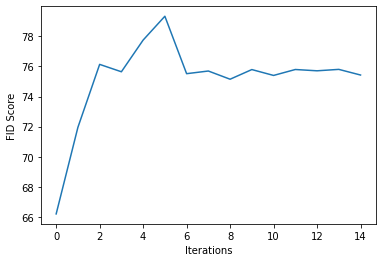

In [207]:
plt.plot(fid_score)
plt.xlabel("Iterations")
plt.ylabel("FID Score")
plt.show()

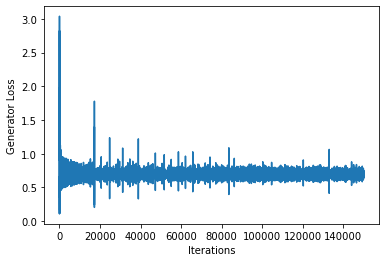

In [208]:
plt.plot(train_gen_loss_array)
plt.xlabel("Iterations")
plt.ylabel("Generator Loss")
plt.show()

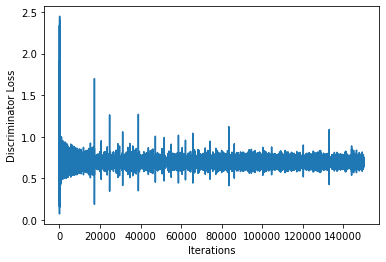

In [209]:
plt.plot(train_dis_loss_array)
plt.xlabel("Iterations")
plt.ylabel("Discriminator Loss")
plt.show()